In [6]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 20]

import streetscape as ss
import osmnx as ox
import nest_asyncio
nest_asyncio.apply()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Street Dataset

In [2]:
osm_street = ox.graph_from_place('Haywards Heath, UK')

In [4]:
# convert osmnx graph to geodataframe
streets = ss.graph2gdf(osm_street)

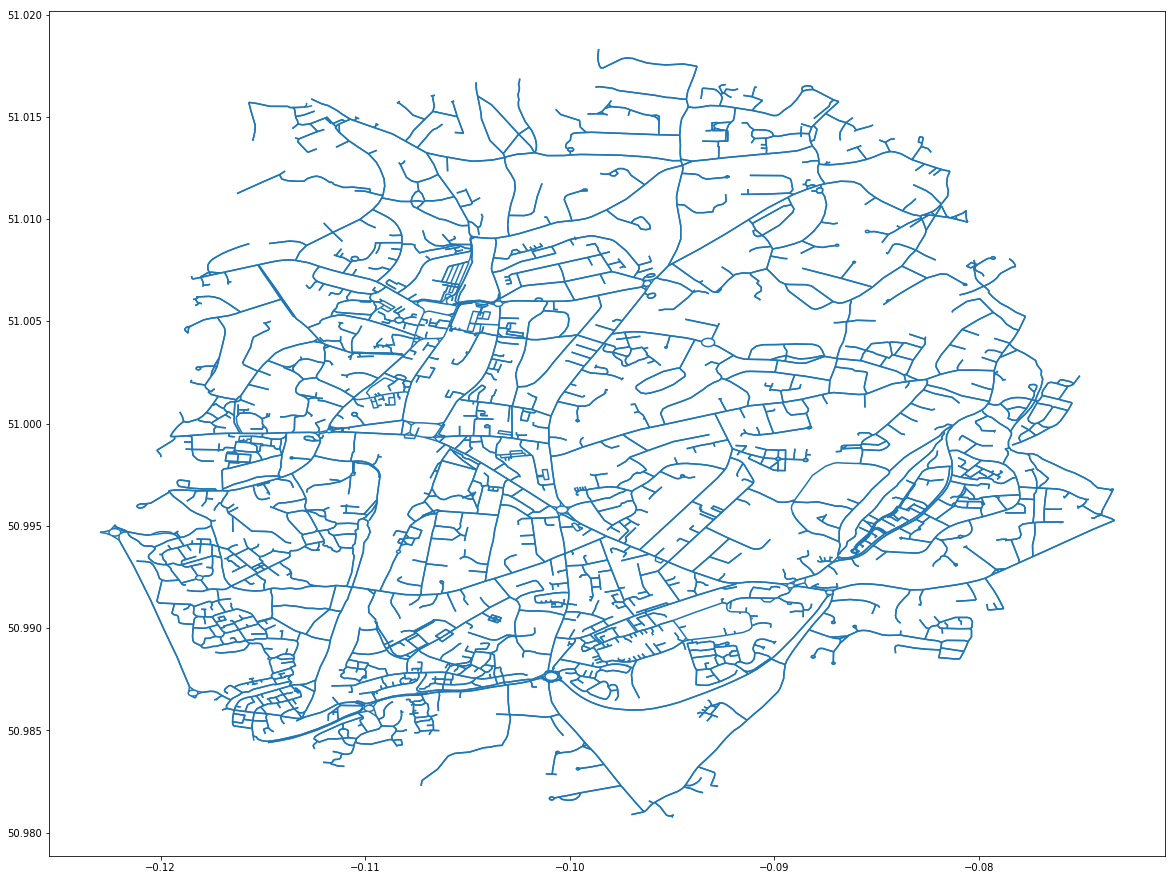

In [7]:
streets.plot()

## Create candidiate grid points
create a 1D grid along with street segments

In [8]:
grids = ss.generate_grids(streets, distance=10)

53025 grid points created


In [9]:
grids.head(10)

,geometry,point_id,seg_end,segment_id,metadata_url
0,POINT (-0.07336670000000001 50.9952681),0,1,5199427,https://maps.googleapis.com/maps/api/streetvie...
1,POINT (-0.07338906852798188 50.99528232036349),1,0,5199427,https://maps.googleapis.com/maps/api/streetvie...
2,POINT (-0.07349814150221824 50.99535106056079),2,0,5199427,https://maps.googleapis.com/maps/api/streetvie...
3,POINT (-0.07361968674006909 50.99539422770838),3,0,5199427,https://maps.googleapis.com/maps/api/streetvie...
4,POINT (-0.07374123197791994 50.99543739485598),4,0,5199427,https://maps.googleapis.com/maps/api/streetvie...
5,POINT (-0.07386277721577079 50.99548056200357),5,0,5199427,https://maps.googleapis.com/maps/api/streetvie...
6,POINT (-0.07398432245362165 50.99552372915117),6,0,5199427,https://maps.googleapis.com/maps/api/streetvie...
7,POINT (-0.0740093 50.9955326),7,-1,5199427,https://maps.googleapis.com/maps/api/streetvie...
8,POINT (-0.07336670000000001 50.9952681),0,1,417954099,https://maps.googleapis.com/maps/api/streetvie...
9,POINT (-0.07337594141471898 50.99526424550272),1,0,417954099,https://maps.googleapis.com/maps/api/streetvie...


## Find GSV points
From each grid candidiate point, we will send a query asking the location of gsv points.

In [26]:
%%time
gsv_points = ss.identify_gsv_locations(grids.head(100))


74 observation points retrieved.
CPU times: user 531 ms, sys: 57.7 ms, total: 589 ms
Wall time: 812 ms


In [27]:
%%time
import requests
import os

urls = list(grids['metadata_url'])
res = list()
for url in urls[0:100]:
    key = os.environ['GSV_API_KEY']
    url = "{}&key={}".format(url, key)
    res.append(requests.get(url))

CPU times: user 1.38 s, sys: 137 ms, total: 1.52 s
Wall time: 6.22 s


In [34]:
gsv_points.head()

,index,copyright,date,pano_id,status,geometry
0,0,© Google,2017-06,u7KgbxNqGUOM0HkucqZRZw,OK,POINT (-0.07496482512436781 50.99455408772208)
1,1,© Google,2017-06,7VbmzX28HsayLzftqCxUKg,OK,POINT (-0.0733641 50.9952888)
2,2,© Google,2017-06,czM6Es1KKgC27hjA_qwv0A,OK,POINT (-0.07373568409303843 50.99509744262802)
3,3,© Google,2017-06,M5-2mpiLVeV664PASI4FNg,OK,POINT (-0.07552570887974486 50.99430005983425)
4,4,© Google,2017-06,pYKClTXjyQXYrHGKUB87lA,OK,POINT (-0.07388683471449316 50.99546628328553)


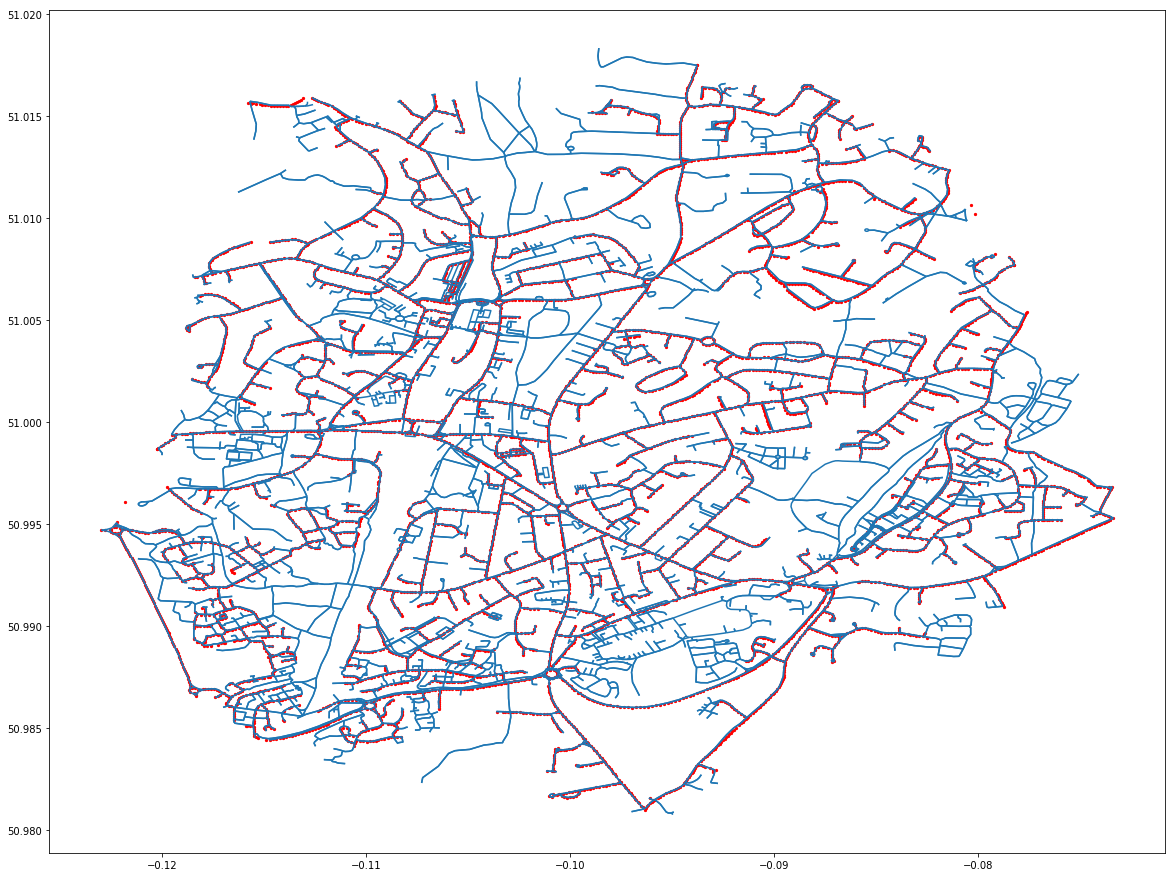

In [60]:
plot_streets = streets.plot()
gsv_points.plot(ax=plot_streets, marker='o', color='red', markersize=5)

## Retrieve GSV images

Although google's cbk API provides an option to download the whole panorama, 
it is not an officially released API. This means we are not sure utilizing the cbk API 
is within the terms of use. 
If you are interested in using cbk API, see robolyst [streetview package](https://github.com/robolyst/streetview)

Here, we are going to use the official street view api even though it does not allow reconstruct the whole
panorama. We are going to use piecewise streetviews from each point.

In [28]:
gsv_urls = ss.make_gsv_urls(gsv_points.head(100))

Total 444 urls created.


In [29]:
ss.download_gsvs(gsv_urls, save_dir='images')